In [1]:
!pip install nltk
import nltk; nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import string
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
!pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from wordcloud import WordCloud

You should consider upgrading via the '/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/bin/python -m pip install --upgrade pip' command.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cbeams/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


You should consider upgrading via the '/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/bin/python -m pip install --upgrade pip' command.


In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [3]:
# Import Dataset
df = pd.read_json('../raw_data/all_data_df_stripped.json')
df.head()

full_transcript       artist  \
0  [rock music playing]\n\n[indistinct chatter]\n...  Adam Devine   
1    strong language. CHEERING Yes, yes, yes! How...    Adam Hess   
2   Ladies and gentlemen, please welcome your hos...   Adam Hills   
3    some strong language and adult humour Ladies...   Adam Hills   
4  ? CHEERING Hello, Apollo. I am going to start ...   Adam Hills   

                                show_name    year                source  \
0                  Best Time Of Our Lives  2019.0  Scraps from the Loft   
1                       Live from the BBC  2016.0                   BBC   
2   Live at the Apollo Series 9 Episode 4  2013.0                   BBC   
3  Live at the Apollo Series 12 Episode 4  2016.0                   BBC   
4   Live at the Apollo Series 5 Episode 5  2009.0                   BBC   

   artist_birthday  artist_gender  age_then  \
0           1983.0              2      36.0   
1           1990.0              2      26.0   
2           1970.0              2      43.0   
3           1970.0              2      46.0   
4           1970.0              2      39.0   

                               full_transcript_clean  
0  man guy much seat guy jacked fully juiced man ...  
1  yes yes yes lovely apologise state voice go co...  
2  tonight london london live amazing act present...  
3  tonight hair lost bet british paralympic team ...  
4  start saying something probably never heard co...

In [10]:
nineties_df = df[df['year'].between(1990, 1999)]

In [11]:
nineties_df.head()

full_transcript      artist  \
55  Recorded in 1991 at the Centaur Theatre during...  Bill Hicks   
57  Recorded Live at Laff Stop, Austin, TX, and Co...  Bill Hicks   
58  Recorded at the London Dominion Theatre in Nov...  Bill Hicks   
59  I don’t know what my deal is, I’ve got a 31 ye...  Bill Hicks   
86  Ladies and gentlemen… live from the world-famo...  Chris Rock   

                                            show_name    year  \
55                                         Relentless  1991.0   
57  Live At Laff Stop, Austin, Tx, And Cobbs, San ...  1993.0   
58                                        Revelations  1993.0   
59  The Censored Seven Minutes On Late Show With D...  1993.0   
86                                   Bigger & Blacker  1999.0   

                  source  artist_birthday  artist_gender  age_then  \
55  Scraps from the Loft           1961.0              2      30.0   
57  Scraps from the Loft           1961.0              2      32.0   
58  Scraps from the Loft           1961.0              2      32.0   
59  Scraps from the Loft           1961.0              2      32.0   
86  Scraps from the Loft           1965.0              2      34.0   

                                full_transcript_clean  
55  centaur theatre annual laugh comedy festival m...  
57  live laff stop austin cobbs san francisco folk...  
58  london dominion theatre november galloping hor...  
59  deal year old curmudgeon deal go dance club da...  
86  gentleman live worldfamous theater harlem new ...

In [12]:
# Convert to list
data = nineties_df.full_transcript_clean.values.tolist()

pprint(data[:1])

['centaur theatre annual laugh comedy festival montreal canada aaaah great '
 'love job love performing love job greatest job world simple reason sharing '
 'horseshit aah fact bos picture envy every job ever bos man always harassed '
 'hick working nothing pretend working pretend working yeaah paid fantasise '
 'pretend mopping knock pretend close bos fired fantasy friend good know bad '
 'attitude man bad attitude great attitude classic face that wrong face people '
 'even walk blue wrong nothing take energy frown smile take energy leave alone '
 'face and watch fucking start smiling hate canada thinking canada cold aah '
 'aih aih aih husky wearing noticed black cotton fucking turtleneck apparently '
 'summertime mean even french province fucking idiot summertime fucking moron '
 'wintertime shapely girl wearing parka locked wearing parka big boot sock '
 'summertime everyone beach understand beach beach beach beach beach love '
 'summertime worm finally beach oooooh fucking deal be

In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['centaur', 'theatre', 'annual', 'laugh', 'comedy', 'festival', 'montreal', 'canada', 'aaaah', 'great', 'love', 'job', 'love', 'performing', 'love', 'job', 'greatest', 'job', 'world', 'simple', 'reason', 'sharing', 'horseshit', 'aah', 'fact', 'bos', 'picture', 'envy', 'every', 'job', 'ever', 'bos', 'man', 'always', 'harassed', 'hick', 'working', 'nothing', 'pretend', 'working', 'pretend', 'working', 'yeaah', 'paid', 'fantasise', 'pretend', 'mopping', 'knock', 'pretend', 'close', 'bos', 'fired', 'fantasy', 'friend', 'good', 'know', 'bad', 'attitude', 'man', 'bad', 'attitude', 'great', 'attitude', 'classic', 'face', 'that', 'wrong', 'face', 'people', 'even', 'walk', 'blue', 'wrong', 'nothing', 'take', 'energy', 'frown', 'smile', 'take', 'energy', 'leave', 'alone', 'face', 'and', 'watch', 'fucking', 'start', 'smiling', 'hate', 'canada', 'thinking', 'canada', 'cold', 'aah', 'aih', 'aih', 'aih', 'husky', 'wearing', 'noticed', 'black', 'cotton', 'fucking', 'turtleneck', 'apparently', 'summe

In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=5) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=5)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['centaur', 'theatre', 'annual', 'laugh', 'comedy', 'festival', 'montreal', 'canada', 'aaaah', 'great', 'love', 'job', 'love', 'performing', 'love', 'job', 'greatest', 'job', 'world', 'simple', 'reason', 'sharing', 'horseshit', 'aah', 'fact', 'bos', 'picture', 'envy', 'every', 'job', 'ever', 'bos', 'man', 'always', 'harassed', 'hick', 'working', 'nothing', 'pretend', 'working', 'pretend', 'working', 'yeaah', 'paid', 'fantasise', 'pretend', 'mopping', 'knock', 'pretend', 'close', 'bos', 'fired', 'fantasy', 'friend', 'good', 'know', 'bad', 'attitude', 'man', 'bad', 'attitude', 'great', 'attitude', 'classic', 'face', 'that', 'wrong', 'face', 'people', 'even', 'walk', 'blue', 'wrong', 'nothing', 'take', 'energy', 'frown', 'smile', 'take', 'energy', 'leave', 'alone', 'face', 'and', 'watch', 'fucking', 'start', 'smiling', 'hate', 'canada', 'thinking', 'canada', 'cold', 'aah', 'aih', 'aih', 'aih', 'husky', 'wearing', 'noticed', 'black', 'cotton', 'fucking', 'turtleneck', 'apparently', 'summer

In [15]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [16]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['annual', 'laugh', 'comedy', 'festival', 'great', 'job', 'love', 'perform', 'love', 'job', 'great', 'job', 'world', 'simple', 'reason', 'share', 'horseshit', 'fact', 'bo', 'picture', 'envy', 'job', 'ever', 'man', 'always', 'harass', 'work', 'pretend', 'working', 'pretend', 'work', 'yeaah', 'pay', 'fantasise', 'pretend', 'mop', 'knock', 'pretend', 'close', 'bo', 'fire', 'fantasy', 'friend', 'good', 'know', 'bad', 'attitude', 'man', 'bad', 'attitude', 'great', 'attitude', 'classic', 'face', 'wrong', 'face', 'people', 'even', 'walk', 'blue', 'wrong', 'take', 'energy', 'smile', 'take', 'energy', 'leave', 'alone', 'face', 'watch', 'fucking', 'start', 'smile', 'think', 'husky', 'wear', 'noticed', 'black', 'cotton', 'fucking', 'apparently', 'summertime', 'mean', 'even', 'french', 'province', 'fuck', 'idiot', 'summertime', 'fuck', 'moron', 'wintertime', 'shapely', 'girl', 'wear', 'parka', 'lock', 'wear', 'parka', 'big', 'boot', 'sock', 'summertime', 'beach', 'understand', 'beach', 'beach', '

In [17]:
def remove_stopw(text, word_list):
    for i in range(len(text)):
        text[i] = [w for w in text[i] if not w in word_list]
    return text

In [25]:
### additional words to remove from the scripts
words_to_remove = ['thank', 'cheering', 'recorded', 'applause', 'laughter', 'laughing', 'murmuring', 'chatter',
                       'aired', 'filmed', 'ladies', 'gentlemen', 'welcome', 'stage', 'transcript', 'netflix',
                  'apollo', 'like', 'goodnight', 'mutter', 'noo', 'nuh', 'oof', 'maan', 'cause', 'okay', 
                   'hey', 'also', 'someone', 'somebody', 'everybody', 'also', 'part' , 'sometimes', 'maybe', 
                   'three', 'second', 'everything', 'minute', 'name', 'kind', 'point', 'yeah', 'hello', 'one', 
                   'two', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'whine', 'hnn', 'malla', 'letta', 
                   'namoo', 'getta', 'nama', 'mana', 'chk','manoo', 'hadda', 'ama', 'carlin',
                  'go', 'know', 'host', 'goodnight', 'get', 'gon', 'think', 'say', 'right', 'look',
                  'thing', 'make', 'know', 'want', 'going', 'would', 'could', 'gentlemen', 'let', 'please',
                   'hbo', 'special' 'yes', 'take', 'say', 'got', 'come', 'see', 'really', 'tell',
                   'well', 'give', 'said', 'people', 'mean', 'even', 'never', 'way', 'happen', 'put', 'much',
                  'lot', 'ever', 'still', 'live', 'quite', 'sort', 'actually', 'use', 'tonight', 'find', 'always',
                  'time', 'good', 'back', 'show', 'little', 'big', 'day', 'talk', 'start', 'need', 'bad', 'first', 'great',
                  'try', 'year', 'word', 'turn', 'bring', 'feel', 'bit', 'ck', 'cke', 'gger', 'ckin', 'groan', 'groan_low', 'groan_high',
                  'high_groan', 'low_groan', 'dingdingde']

decade_cleanup = ['fuck', 'fucking', 'shit', 'motherfucker', 'man', 'woman', 'guy']
                    
                    # 'know'? 'go'? 'fuck'?
    
                    # haven't left 'i'm' etc. as those should be cleaned up
                    # by a mixture of stopwords, punctuation removeal, lemmatizing and minimum length

remove_stopw(data_lemmatized, stopwords.words('english'))
remove_stopw(data_lemmatized, words_to_remove)
remove_stopw(data_lemmatized, decade_cleanup)

[['annual',
  'laugh',
  'comedy',
  'festival',
  'job',
  'love',
  'perform',
  'love',
  'job',
  'job',
  'world',
  'simple',
  'reason',
  'share',
  'horseshit',
  'fact',
  'bo',
  'picture',
  'envy',
  'job',
  'harass',
  'work',
  'pretend',
  'working',
  'pretend',
  'work',
  'yeaah',
  'pay',
  'fantasise',
  'pretend',
  'mop',
  'knock',
  'pretend',
  'close',
  'bo',
  'fire',
  'fantasy',
  'friend',
  'attitude',
  'attitude',
  'attitude',
  'classic',
  'face',
  'wrong',
  'face',
  'walk',
  'blue',
  'wrong',
  'energy',
  'smile',
  'energy',
  'leave',
  'alone',
  'face',
  'watch',
  'smile',
  'husky',
  'wear',
  'noticed',
  'black',
  'cotton',
  'apparently',
  'summertime',
  'french',
  'province',
  'idiot',
  'summertime',
  'moron',
  'wintertime',
  'shapely',
  'girl',
  'wear',
  'parka',
  'lock',
  'wear',
  'parka',
  'boot',
  'sock',
  'summertime',
  'beach',
  'understand',
  'beach',
  'beach',
  'beach',
  'beach',
  'love',
  'summ

In [26]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 3), (3, 1), (4, 1), (5, 1), (6, 1), (7, 4), (8, 1), (9, 2), (10, 1), (11, 1), (12, 2), (13, 1), (14, 3), (15, 1), (16, 4), (17, 1), (18, 6), (19, 1), (20, 1), (21, 3), (22, 3), (23, 1), (24, 8), (25, 2), (26, 2), (27, 1), (28, 2), (29, 2), (30, 1), (31, 6), (32, 1), (33, 1), (34, 1), (35, 3), (36, 2), (37, 1), (38, 1), (39, 4), (40, 3), (41, 14), (42, 1), (43, 2), (44, 1), (45, 3), (46, 4), (47, 2), (48, 1), (49, 1), (50, 1), (51, 2), (52, 3), (53, 4), (54, 1), (55, 2), (56, 1), (57, 1), (58, 1), (59, 1), (60, 4), (61, 1), (62, 1), (63, 1), (64, 1), (65, 9), (66, 1), (67, 1), (68, 1), (69, 3), (70, 1), (71, 2), (72, 6), (73, 1), (74, 1), (75, 13), (76, 1), (77, 1), (78, 1), (79, 2), (80, 1), (81, 1), (82, 1), (83, 3), (84, 1), (85, 5), (86, 1), (87, 1), (88, 2), (89, 1), (90, 2), (91, 1), (92, 1), (93, 3), (94, 1), (95, 1), (96, 1), (97, 1), (98, 4), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 2), (106, 2), (107, 1), (108, 2), (109, 1), (110, 

In [27]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=31,
                                            random_state=100,
                                            update_every=10,
                                            chunksize=15,
                                            passes=10,
                                            alpha=0.4,
                                            eta=0.5,
                                            per_word_topics=True)

In [28]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(19,
  '0.001*"abortion" + 0.001*"prolife" + 0.001*"chicken" + 0.001*"fetus" + '
  '0.001*"consistency" + 0.000*"catholic" + 0.000*"conservative" + '
  '0.000*"fertilize" + 0.000*"antiabortion" + 0.000*"antiwoman"'),
 (21,
  '0.000*"work" + 0.000*"call" + 0.000*"child" + 0.000*"kid" + 0.000*"hear" + '
  '0.000*"life" + 0.000*"car" + 0.000*"walk" + 0.000*"watch" + 0.000*"kill"'),
 (23,
  '0.000*"call" + 0.000*"life" + 0.000*"car" + 0.000*"love" + 0.000*"hear" + '
  '0.000*"watch" + 0.000*"kid" + 0.000*"work" + 0.000*"end" + 0.000*"run"'),
 (8,
  '0.000*"kid" + 0.000*"call" + 0.000*"love" + 0.000*"work" + 0.000*"life" + '
  '0.000*"hear" + 0.000*"keep" + 0.000*"country" + 0.000*"eat" + 0.000*"kill"'),
 (7,
  '0.000*"kill" + 0.000*"hear" + 0.000*"kid" + 0.000*"work" + 0.000*"head" + '
  '0.000*"life" + 0.000*"die" + 0.000*"call" + 0.000*"keep" + 0.000*"run"'),
 (14,
  '0.000*"kid" + 0.000*"call" + 0.000*"work" + 0.000*"life" + 0.000*"hear" + '
  '0.000*"leave" + 0.000*"car" + 0.000*"eat"

In [29]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.187546255376663

Coherence Score:  0.24519226286686838


In [30]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds='mmds')
vis

/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.029694 -0.145879       1        1  40.653470
5     -0.083939 -0.059834       2        1  14.989194
25     0.029167 -0.085508       3        1  12.865013
24     0.076060 -0.059988       4        1  12.460986
17     0.089457 -0.013822       5        1  10.170548
4      0.069147  0.045192       6        1   7.828686
11    -0.008952  0.009590       7        1   0.228984
1     -0.010213  0.013170       8        1   0.173126
19    -0.008482  0.011845       9        1   0.027557
13    -0.008171  0.012827      10        1   0.027396
16    -0.008182  0.012845      11        1   0.027394
23    -0.008192  0.012872      12        1   0.027393
3     -0.008246  0.012931      13        1   0.027388
12    -0.008268  0.012956      14        1   0.027385
6     -0.008262  0.012945      15        1   0.027385
8     -0.008267  0.012959      16        1   0.027384
20    -0.008279  0.012975      17        1   0.027383
10    -0.008281  0.012973      18        1   0.027382
7     -0.008282  0.012982      19        1   0.027382
0     -0.008285  0.012981      20        1   0.027382
22    -0.008289  0.012990      21        1   0.027382
14    -0.008285  0.012992      22        1   0.027381
30    -0.008289  0.012986      23        1   0.027381
27    -0.008286  0.012986      24        1   0.027381
2     -0.008287  0.012995      25        1   0.027381
26    -0.008293  0.012995      26        1   0.027381
21    -0.008296  0.013003      27        1   0.027380
18    -0.008295  0.013006      28        1   0.027379
29    -0.008300  0.013009      29        1   0.027379
28    -0.008302  0.013012      30        1   0.027379
9     -0.008304  0.013014      31        1   0.027378, topic_info=          Term        Freq       Total Category  logprob  loglift
175    country   75.000000   75.000000  Default  30.0000  30.0000
3245       cat   45.000000   45.000000  Default  29.0000  29.0000
1134       egg   31.000000   31.000000  Default  28.0000  28.0000
849       walk   67.000000   67.000000  Default  27.0000  27.0000
120       call  113.000000  113.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
859       wear    0.001474   44.538431  Topic31  -8.7959  -2.1132
228       drug    0.001477   57.303007  Topic31  -8.7934  -2.3627
633   remember    0.001475   51.424975  Topic31  -8.7949  -2.2561
849       walk    0.001478   67.533204  Topic31  -8.7930  -2.5267
855      watch    0.001475   78.260301  Topic31  -8.7951  -2.6762

[2094 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2         4  0.573232       abduct
897       1  0.739211     abortion
897       2  0.211203     abortion
897       3  0.052801     abortion
3665      6  0.690708      achille
...     ...       ...          ...
884       3  0.083068        wrong
884       4  0.110757        wrong
884       5  0.055379        wrong
884       6  0.055379        wrong
895       4  0.698743  yul_brynner

[1465 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 6, 26, 25, 18, 5, 12, 2, 20, 14, 17, 24, 4, 13, 7, 9, 21, 11, 8, 1, 23, 15, 31, 28, 3, 27, 22, 19, 30, 29, 10])

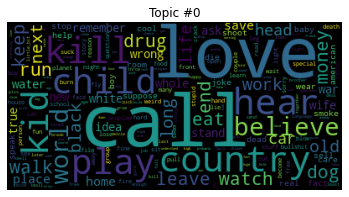

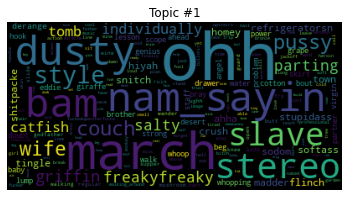

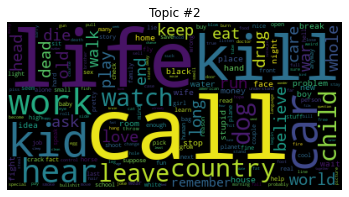

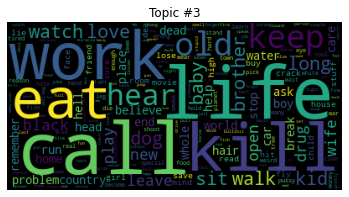

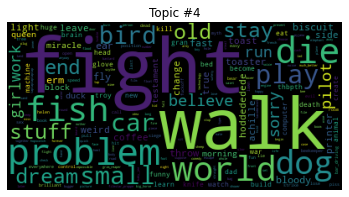

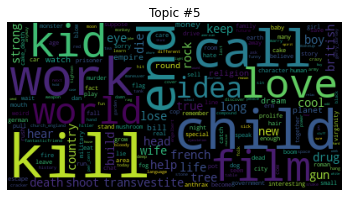

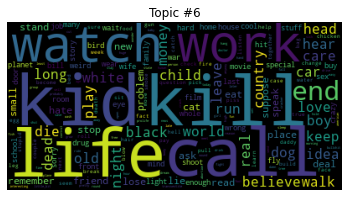

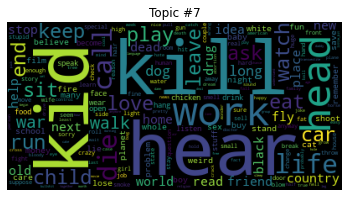

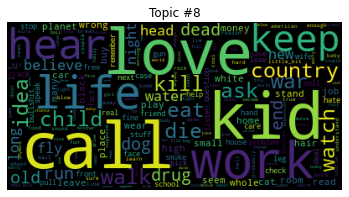

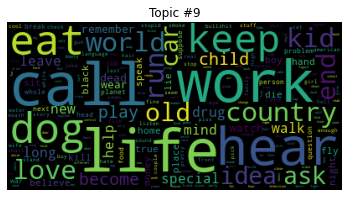

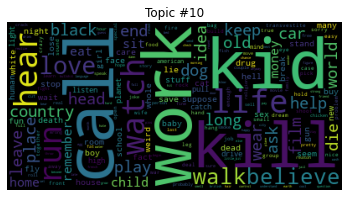

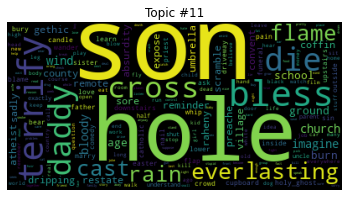

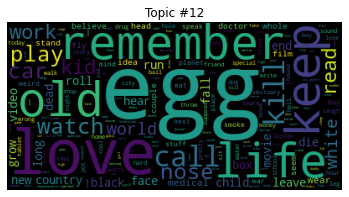

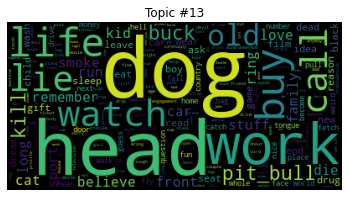

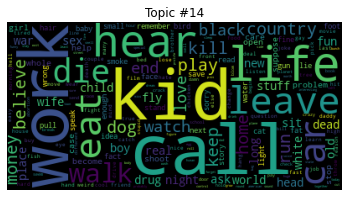

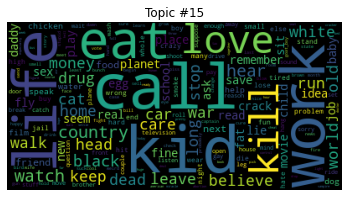

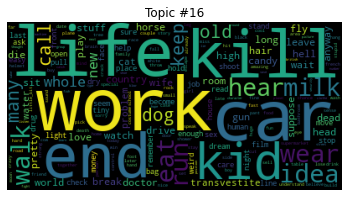

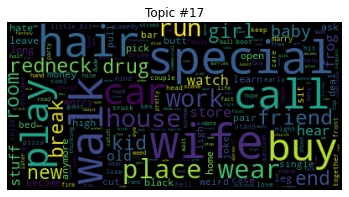

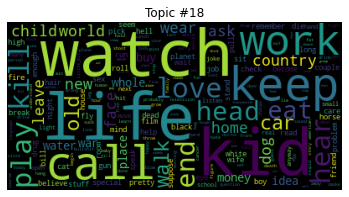

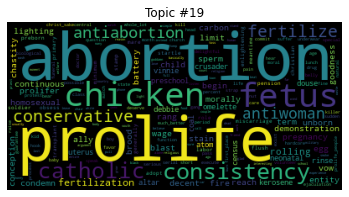

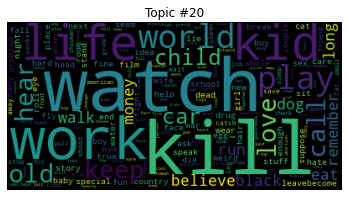

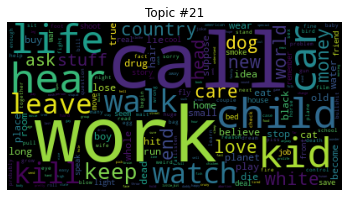

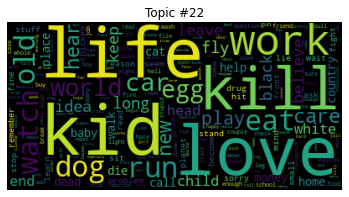

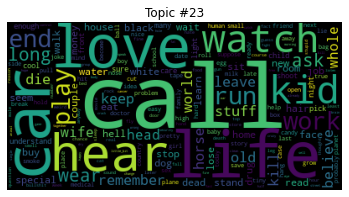

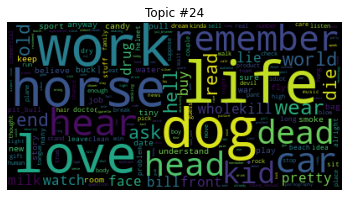

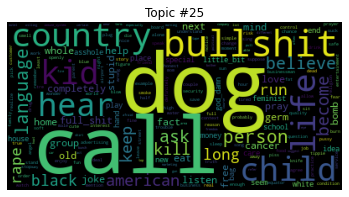

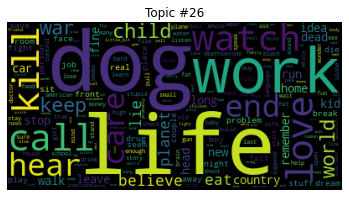

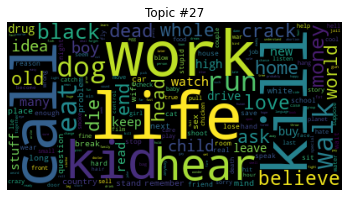

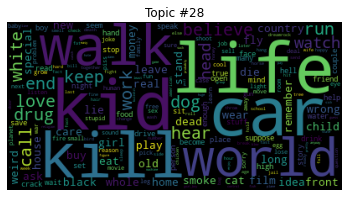

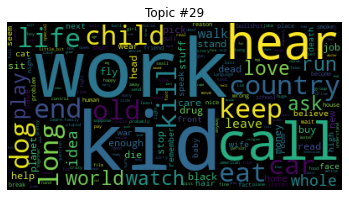

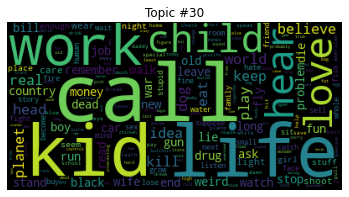

/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__)

/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/cbeams/.pyenv/versions/3.8.12/envs/objectively_funny/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__)

In [31]:
# lda is assumed to be the variable holding the LdaModel object
import matplotlib.pyplot as plt
for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()